In [1]:
def download(path):
    import os
    from six.moves import urllib

    fname = path.split('/')[-1]
    if os.path.exists(fname):
        return fname

    print('Downloading ' + path)

    def progress(count, block_size, total_size):
        if count % 20 == 0:
            print('Downloaded %02.02f/%02.02f MB' % (
                count * block_size / 1024.0 / 1024.0,
                total_size / 1024.0 / 1024.0), end='\r')

    filepath, _ = urllib.request.urlretrieve(
        path, filename=fname, reporthook=progress)
    return filepath

In [2]:
download('http://images.math.cnrs.fr/IMG/jpg/Fractal1-2.jpg')


'Fractal1-2.jpg'

In [3]:
download('http://www.picturepurrfect.com/uploads/9/7/8/3/9783148/1740884.jpg')

'1740884.jpg'

In [4]:
import tensorflow as tf
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize

def get_vgg_model():
    download('https://s3.amazonaws.com/cadl/models/vgg16.tfmodel')
    with open("vgg16.tfmodel", mode='rb') as f:
        graph_def = tf.GraphDef()
        try:
            graph_def.ParseFromString(f.read())
        except:
            print('try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ' +
                  'to environment.  e.g.:\n' +
                  'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython\n' +
                  'See here for info: ' +
                  'https://github.com/tensorflow/tensorflow/issues/582')

    download('https://s3.amazonaws.com/cadl/models/synset.txt')
    with open('synset.txt') as f:
        labels = [(idx, l.strip()) for idx, l in enumerate(f.readlines())]

    return {
        'graph_def': graph_def,
        'labels': labels,
        'preprocess': preprocess,
        'deprocess': deprocess
    }


def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)


def deprocess(img):
    return np.clip(img * 255, 0, 255).astype(np.uint8)

In [5]:
from IPython.display import display, HTML
def show_graph(graph_def):
    def _strip_consts(graph_def, max_const_size=32):
        strip_def = tf.GraphDef()
        for n0 in graph_def.node:
            n = strip_def.node.add()
            n.MergeFrom(n0)
            if n.op == 'Const':
                tensor = n.attr['value'].tensor
                size = len(tensor.tensor_content)
                if size > max_const_size:
                    tensor.tensor_content = "<stripped {} bytes>".format(size).encode()
        return strip_def

    def _rename_nodes(graph_def, rename_func):
        res_def = tf.GraphDef()
        for n0 in graph_def.node:
            n = res_def.node.add()
            n.MergeFrom(n0)
            n.name = rename_func(n.name)
            for i, s in enumerate(n.input):
                n.input[i] = rename_func(s) if s[0] != '^' else '^' + rename_func(s[1:])
        return res_def

    def _show_entire_graph(graph_def, max_const_size=32):
        if hasattr(graph_def, 'as_graph_def'):
            graph_def = graph_def.as_graph_def()
        strip_def = _strip_consts(graph_def, max_const_size=max_const_size)
        code = """
            <script>
              function load() {{
                document.getElementById("{id}").pbtxt = {data};
              }}
            </script>
            <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
            <div style="height:600px">
              <tf-graph-basic id="{id}"></tf-graph-basic>
            </div>
        """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

        iframe = """
            <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
        """.format(code.replace('"', '&quot;'))
        display(HTML(iframe))
    tmp_def = _rename_nodes(graph_def, lambda s: "/".join(s.split('_', 1)))
    _show_entire_graph(tmp_def)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def build_gif(imgs, interval=0.1, dpi=72,
              save_gif=True, saveto='animation.gif',
              show_gif=False, cmap=None):
    imgs = np.asarray(imgs)
    h, w, *c = imgs[0].shape
    fig, ax = plt.subplots(figsize=(np.round(w / dpi), np.round(h / dpi)))
    fig.subplots_adjust(bottom=0)
    fig.subplots_adjust(top=1)
    fig.subplots_adjust(right=1)
    fig.subplots_adjust(left=0)
    ax.set_axis_off()

    if cmap is not None:
        axs = list(map(lambda x: [
            ax.imshow(x, cmap=cmap)], imgs))
    else:
        axs = list(map(lambda x: [
            ax.imshow(x)], imgs))

    ani = animation.ArtistAnimation(
        fig, axs, interval=interval, repeat_delay=0, blit=True)

    if save_gif:
        ani.save(saveto, writer='imagemagick', dpi=dpi)

    if show_gif:
        plt.show()

    return ani

In [7]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
import IPython.display as ipyd
import tensorflow as tf
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [8]:
net = get_vgg_model()

0 255


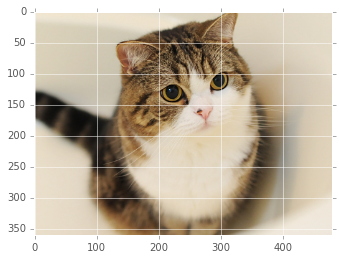

In [9]:
og = plt.imread('cat.jpg')[..., :3]
plt.imshow(og)
print(og.min(), og.max())

In [18]:
img = net['preprocess'](og)
print(img.min(), img.max())

7.0 242.0


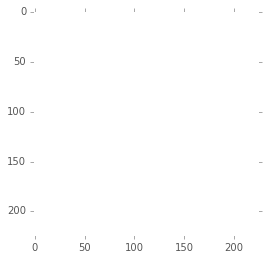

In [19]:
deprocessed = net['deprocess'](img)
plt.imshow(deprocessed)
plt.show()

In [ ]:
show_graph(net['graph_def'])

In [ ]:
label_i = 851
print(net['labels'][label_i])

In [ ]:
g = tf.Graph()
with tf.Session(graph=g) as sess:
    tf.import_graph_def(net['graph_def'], name='net')
    names = [op.name for op in g.get_operations()]
    features = [name + ':0' for name in names if 'pool' in name]
    print(features)
    x = g.get_tensor_by_name(names[0] + ':0')
    print(x.name)

In [ ]:
def plot_gradient(img, x, feature, g, device='/cpu:0'):
    with tf.Session(graph=g) as sess:
        saliency = tf.gradients(tf.reduce_mean(feature), x)
        this_res = sess.run(saliency[0], feed_dict={x: img})
        grad = this_res[0] / np.max(np.abs(this_res))
        return grad
    
def normalize(a, s=0.1):
    return np.uint8(np.clip(
        (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5,
        0, 1) * 255)

In [ ]:
img = net['preprocess'](og)[np.newaxis]
fig, axs = plt.subplots(1, len(features), figsize=(20, 10))

for i in range(len(features)):
    axs[i].set_title(features[i])
    grad = plot_gradient(img, x, g.get_tensor_by_name(features[i]), g)
    axs[i].imshow(normalize(grad))

In [ ]:
def dream(img, gradient, step, net, x, n_iterations=50, plot_step=10):
    img_copy = img.copy()
    fig, axs = plt.subplots(1, n_iterations // plot_step, figsize=(20, 10))
    with tf.Session(graph=g) as sess:
        for it_i in range(n_iterations):
            this_res = sess.run(gradient[0], feed_dict={x: img_copy})[0]
            this_res /= (np.max(np.abs(this_res) + 1e-8))            
            img_copy += this_res * step
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])
                axs[it_i // plot_step].imshow(m)

In [ ]:
n_iterations = 3
step = 1.0
plot_step = 1
for feature_i in range(len(features)):
    with tf.Session(graph=g) as sess:
        layer = g.get_tensor_by_name(features[feature_i])
        gradient = tf.gradients(tf.reduce_mean(layer), x)
        dream(img, gradient, step, net, x, n_iterations=n_iterations, plot_step=plot_step)

In [ ]:
noise = net['preprocess'](np.random.rand(256, 256, 3) * 0.1 + 0.45)[np.newaxis]
for feature_i in range(len(features)):
    with tf.Session(graph=g) as sess:
        layer = g.get_tensor_by_name(features[feature_i])
        gradient = tf.gradients(tf.reduce_mean(layer), x)
        dream(noise, gradient, step, net, x, n_iterations=n_iterations, plot_step=plot_step)

In [ ]:
print(names[-2])
layer = g.get_tensor_by_name(names[-2] + ":0")
with tf.Session(graph=g) as sess:
    layer_shape = tf.shape(layer).eval(feed_dict={x:img})
    n_els = layer_shape[-1]
    print(n_els)

In [ ]:
print(net['labels'])

In [ ]:
neuron_i = 43
print(net['labels'][neuron_i])

In [ ]:
esher_og = plt.imread('threeworlds.jpg')
print(esher_og.shape)
plt.imshow(esher_og)
esher = net['preprocess'](og)[np.newaxis]
print(esher.shape)

In [ ]:
layer_vec = np.ones(layer_shape) / 100.0
layer_vec[..., neuron_i] = 0.99

In [ ]:
n_iterations = 51
plot_step = 5
step = 0.2
imgs = []
with tf.Session(graph=g) as sess:
    gradient = tf.gradients(tf.reduce_max(layer), x)
    img_copy = img.copy()
    with tf.Session(graph=g) as sess:
        for it_i in range(n_iterations):
            this_res = sess.run(gradient[0], feed_dict={x: img_copy, layer: layer_vec})[0]
            this_res /= (np.max(np.abs(this_res) + 1e-8))
            img_copy += this_res * step
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])
                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()                
                imgs.append(m)

In [ ]:
build_gif(imgs, saveto='softmax.gif')

In [ ]:
#ipyd.Image(url='softmax.gif?i={}'.format(np.random.rand()), height=300, width=300)

In [ ]:
n_iterations = 101
plot_step = 10
step = 0.1
crop = 1
imgs = []

n_imgs, height, width, *ch = img.shape
with tf.Session(graph=g) as sess:
    gradient = tf.gradients(tf.reduce_max(layer), x)
    img_copy = img.copy()
    with tf.Session(graph=g) as sess:
        for it_i in range(n_iterations):
            this_res = sess.run(gradient[0], feed_dict={x: img_copy, layer: layer_vec})[0]
            this_res = this_res / (np.max(np.abs(this_res)) + 1e-10)
            img_copy += this_res * step
            img_copy = img_copy[:, crop:-crop, crop:-crop, :]
            img_copy = resize(img_copy[0], (height, width), order=3,clip=False, preserve_range=True)[np.newaxis].astype(np.float32)
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])
                plt.grid('off')
                plt.imshow(m)
                plt.show()                
                imgs.append(m)

In [ ]:
build_gif(imgs, saveto='fractal.gif')
#ipyd.Image(url='fractal.gif?i=2', height=300, width=300)

In [ ]:
download('https://www.laetusinpraesens.org/docs00s/images/cardioid_files/mandel_bud.png')

In [ ]:
guide_og = plt.imread('mandelbrot3.png')[..., :3]
dream_og = plt.imread('tabby.jpg')[..., :3]

assert(guide_og.ndim == 3 and guide_og.shape[-1] == 3)
assert(dream_og.ndim == 3 and dream_og.shape[-1] == 3)
plt.imshow(dream_og)

In [ ]:
plt.imshow(guide_og)

In [ ]:
guide_img = net['preprocess'](guide_og)[np.newaxis]
dream_img = net['preprocess'](dream_og)[np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(guide_og)
axs[1].imshow(dream_og)

In [ ]:
x = g.get_tensor_by_name(names[0] + ":0")
feature_loss_weight = 1.0

with tf.Session(graph=g) as sess:
    feature_loss = tf.Variable(0.0)
    for feature_i in features[3:5]:
        layer = g.get_tensor_by_name(feature_i)
        guide_layer = sess.run(layer, feed_dict={x: guide_img})
        layer = tf.reshape(layer, [-1, 1])
        guide_layer = guide_layer.reshape(-1, 1)
        correlation = tf.matmul(guide_layer.T, layer)
        feature_loss += feature_loss_weight * correlation
        
n_img, height, width, ch = dream_img.shape
tv_loss_weight = 1.0

with tf.Session(graph=g) as sess:
    dx = tf.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    dy = tf.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    tv_loss = tv_loss_weight * tf.reduce_mean(tf.pow(dx + dy, 1.2))
    
step = 0.1

imgs = []

with tf.Session(graph=g) as sess:
    gradient = tf.gradients(-tv_loss + feature_loss, x)
    img_copy = dream_img.copy()

    with tf.Session(graph=g) as sess:
        sess.run(tf.initialize_all_variables())        
        for it_i in range(n_iterations):
            this_res = sess.run(gradient[0], feed_dict={x: img_copy})[0]
            this_res /= (np.max(np.abs(this_res) + 1e-8))
            img_copy += this_res * step
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])
                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()                
                imgs.append(m)

build_gif(imgs, saveto='guided.gif')    

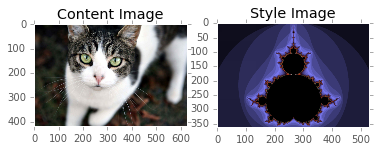

In [42]:
content_og = plt.imread('tabby.jpg')[..., :3]
style_og = plt.imread('mandelbrot3.png')[..., :3]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')


In [44]:
tf.reset_default_graph()
g = tf.Graph()
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = [] 
    
with tf.Session(graph=g) as sess:
    tf.import_graph_def(net['graph_def'], name='net')
    names = [op.name for op in g.get_operations()]
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={x: content_img, 'net/dropout_1/random_uniform:0': [[1.0]], 'net/dropout/random_uniform:0': [[1.0]]})
        style_activations.append(style_activation_i)
#     style_features = []
#     for style_activation_i in style_activations:
#         s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
#         gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
#         style_features.append(gram_matrix.astype(np.float32))
    


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("net/images:0", dtype=float32) is not an element of this graph.